# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster from the Freie Universität Berlin.

_Note_:
The notebook will run using the results stored in the `output` folder. They were generated using the following:
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --string-encoding smiles --aug-strategy-train no_augmentation --aug-strategy-test no_augmentation --aug-nb-train 0 --aug-nb-test 0 --ml-model CONV1D --eval-strategy True
```

📝 Have a look at the [README](https://github.com/volkamerlab/maxsmi/blob/main/README.md) page for more details.

## Canonical VS Random SMILES: Performance Comparison

### Goal

The aim of this notebook is to compare the results on the test set for the models that use the canonical or one random SMILES, and try to explain why the performance is systemically better for canonical SMILES.

In [1]:
import os
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from maxsmi.utils_analysis import load_results
from maxsmi.utils_smiles import get_num_heavy_atoms

In [2]:
# Path to this notebook
HERE = Path(_dh[-1])

In [3]:
path_to_output = HERE.parents[0]

## Dataset
We consider the following datasets:

- ESOL
- free_solv
- lipophilicity

Comment/uncomment the dataset of choice in the cell below.

In [4]:
# TASK = "lipophilicity"
# TASK = "free_solv"
TASK = "ESOL"

## Load results

Load results from random SMILES.

In [5]:
test_data = load_results(path_to_output,
                         TASK,
                         "augmentation_with_duplication",
                         1,
                         "augmentation_with_duplication",
                         1,
                         "CONV1D",
                         "smiles",
                         True)
test_data = test_data.rename(columns={"average_\
prediction": "random_prediction"})
test_data = test_data.drop(columns=["std_prediction", "new_smiles"])
test_data.head()

,target,canonical_smiles,augmented_smiles,random_prediction
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,[CC(C)(c1ccc(OCC)cc1)COCc1cccc(c1)Oc1ccccc1],-7.217669
277,-0.60,CCS,[C(C)S],-0.594701
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,[O(C(C)=O)CC(OC(C)=O)COC(=O)C],0.105230
937,-0.67,CCC(C)C(C)=O,[C(C)C(C(C)=O)C],-1.519783
444,-5.05,C=CCCCCCCC,[C(CCCCCCC)=C],-5.072193


Load results from canonical SMILES.

In [6]:
test_data_canonical = load_results(path_to_output,
                                   TASK,
                                   "no_augmentation",
                                   0,
                                   "no_augmentation",
                                   0,
                                   "CONV1D",
                                   "smiles",
                                   True)
test_data_canonical = test_data_canonical.rename(columns={"average_\
prediction": "canonical_prediction"})
test_data_canonical = test_data_canonical.drop(columns=["std_prediction",
                                                        "new_smiles"])
test_data_canonical.head()

,target,canonical_smiles,augmented_smiles,canonical_prediction
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,[CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1],-6.255364
277,-0.60,CCS,[CCS],-0.779630
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,[CC(=O)OCC(COC(C)=O)OC(C)=O],0.379165
937,-0.67,CCC(C)C(C)=O,[CCC(C)C(C)=O],-1.765576
444,-5.05,C=CCCCCCCC,[C=CCCCCCCC],-4.743603


### Merge results into one dataframe

Add canonical result to random result dataframe, (`canonical_prediction` and `random_prediction`, respectively).

In [7]:
test_data["canonical_prediction"] = test_data_canonical["canonical_prediction"]
test_data.head()

,target,canonical_smiles,augmented_smiles,random_prediction,canonical_prediction
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,[CC(C)(c1ccc(OCC)cc1)COCc1cccc(c1)Oc1ccccc1],-7.217669,-6.255364
277,-0.60,CCS,[C(C)S],-0.594701,-0.779630
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,[O(C(C)=O)CC(OC(C)=O)COC(=O)C],0.105230,0.379165
937,-0.67,CCC(C)C(C)=O,[C(C)C(C(C)=O)C],-1.519783,-1.765576
444,-5.05,C=CCCCCCCC,[C(CCCCCCC)=C],-5.072193,-4.743603


### Prediction error
Look at the errors between the target, or true value, and the prediction for the canonical vs random SMILES (`canonical_error` and `random_error`, respectively).

In [8]:
test_data["random_error"] = (test_data["target"] -
                             test_data["random_prediction"]).abs()
test_data["canonical_error"] = (test_data["target"] -
                                test_data["canonical_prediction"]).abs()
test_data.head()

,target,canonical_smiles,augmented_smiles,random_prediction,canonical_prediction,random_error,canonical_error
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,[CC(C)(c1ccc(OCC)cc1)COCc1cccc(c1)Oc1ccccc1],-7.217669,-6.255364,1.382331,2.344636
277,-0.60,CCS,[C(C)S],-0.594701,-0.779630,0.005299,0.179630
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,[O(C(C)=O)CC(OC(C)=O)COC(=O)C],0.105230,0.379165,0.705230,0.979165
937,-0.67,CCC(C)C(C)=O,[C(C)C(C(C)=O)C],-1.519783,-1.765576,0.849783,1.095576
444,-5.05,C=CCCCCCCC,[C(CCCCCCC)=C],-5.072193,-4.743603,0.022193,0.306397


### Size of molecules
Compute the number of heavy atoms in each molecule.

In [9]:
test_data["num_heavy_atoms"] = test_data["canonical_\
smiles"].apply(get_num_heavy_atoms)

### Analyze the error differences
Plot the individual prediction errors against each other

<AxesSubplot:xlabel='canonical_error', ylabel='random_error'>

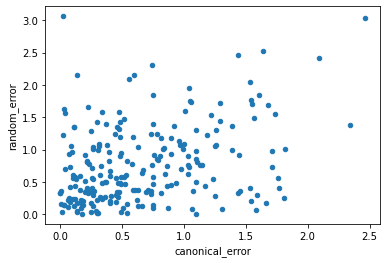

In [10]:
test_data.plot.scatter(x='canonical_error', y='random_error')

Check for examples with high error difference

In [11]:
test_data["abs_diff_canonical_random_error"] = (test_data["canonical_error"] -
                             test_data["random_error"]).abs()
test_data["canonical_better"] = (test_data["canonical_error"] <=
                             test_data["random_error"])
test_data.sort_values("abs_diff_canonical_random_error", ascending=False).head()

,target,canonical_smiles,augmented_smiles,random_prediction,canonical_prediction,random_error,canonical_error,num_heavy_atoms,abs_diff_canonical_random_error,canonical_better
500,-6.340,CCOP(=S)(OCC)SC(CCl)N1C(=O)c2ccccc2C1=O,[N1(C(=O)c2ccccc2C1=O)C(SP(=S)(OCC)OCC)CCl],-3.281174,-6.317289,3.058826,0.022711,23,3.036115,True
319,-7.210,Clc1cc(Cl)c(-c2cccc(Cl)c2Cl)cc1Cl,[Clc1c(-c2cccc(Cl)c2Cl)cc(Cl)c(Cl)c1],-9.368914,-7.346202,2.158914,0.136202,17,2.022712,True
936,-3.540,O=[N+]([O-])c1cccc2ccccc12,[c12c(cccc2cccc1)[N+](=O)[O-]],-5.165521,-3.505774,1.625521,0.034226,13,1.591295,True
272,-8.402,CC1(C)C(C=C(Br)Br)C1C(=O)OC(C#N)c1cccc(Oc2cccc...,[CC1(C(C(OC(c2cccc(c2)Oc2ccccc2)C#N)=O)C1C=C(B...,-6.090784,-7.658781,2.311216,0.743219,28,1.567997,True
922,-3.931,O=C1NC(=O)C2C3C(C(O)(c4ccccc4)c4ccccn4)=CC(C3=...,[c1(ccccc1)C(c1ccccn1)(O)C1C2C(C(C3C(=O)NC(=O)...,-4.176924,-5.737419,0.245924,1.806419,39,1.560495,False


In [12]:
top_n = 15
print(f"From top {top_n} molecules (total {test_data.shape[0]}) with highest error difference\
    {test_data.sort_values('abs_diff_canonical_random_error', ascending=False)[0:top_n].canonical_better.sum()}\
    are better predicted using canonical SMILES.")

From top 15 molecules (total 226) with highest error difference    9    are better predicted using canonical SMILES.


Draw the molecules

In [13]:
test_data.sort_values("abs_diff_canonical_random_error", ascending=False).index[:15]

Int64Index([500, 319, 936, 272, 922, 265, 394, 825, 780, 1095, 703, 971, 326,
            1052, 976],
           dtype='int64')

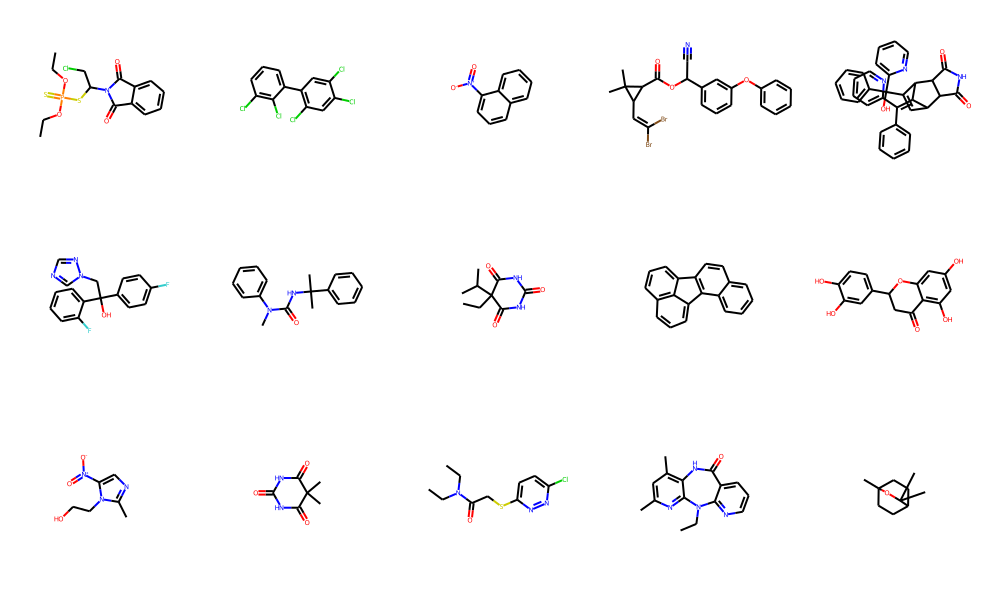

In [14]:
# Get SMILES
smiList = test_data.loc[[500, 319, 936, 272, 922, 265, 394, 825, 780, 1095, 
                         703, 971, 326, 1052, 976]].canonical_smiles 
# Create RDKit molecular objects
mols = [Chem.MolFromSmiles(m) for m in smiList]
# display
Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(200,200))

## Canonical VS random SMILES
Consider molecules that are better predicted if canonical SMILES are used.

In [15]:
better_canonical = test_data[(test_data['random_error'] >
                              test_data['canonical_error'])]
better_canonical.head()

,target,canonical_smiles,augmented_smiles,random_prediction,canonical_prediction,random_error,canonical_error,num_heavy_atoms,abs_diff_canonical_random_error,canonical_better
405,-4.630,CC(=O)OCC(=O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,[C(OCC(=O)C1CCC2C3CCC4C(C)(C3CCC12C)CCC(=O)C=4...,-3.406039,-4.655402,1.223961,0.025402,27,1.198559,True
1039,-4.173,CC(=O)SC1CC2=CC(=O)CCC2(C)C2CCC3(C)C(CCC34CCC(...,[C12C(CCC3(C)C4(OC(CC4)=O)CCC31)C1(C(CC2SC(=O)...,-5.916536,-5.219800,1.743536,1.046800,29,0.696736,True
485,-0.220,COP(=O)(OC)C(O)C(Cl)(Cl)Cl,[O(P(=O)(C(C(Cl)(Cl)Cl)O)OC)C],-1.352779,-1.182500,1.132779,0.962500,12,0.170279,True
1051,-1.470,CCCCC(O)CC,[C(CCC)C(CC)O],-2.485096,-1.733256,1.015096,0.263256,8,0.751840,True
643,-4.370,c1ccc2c(c1)CCCC2,[c1cc2c(cc1)CCCC2],-3.453131,-3.608530,0.916869,0.761470,10,0.155399,True


In [16]:
for ind, (index, row) in enumerate(better_canonical.iterrows()):
    if ind < 3:
        if row["num_heavy_atoms"] >= 5:
            print(f"Index: {index}\n"
                  f"Target: {row['target']:.2f}\n"
                  f"Canonical SMILES: {row['canonical_smiles']}\n"
                  f"Canonical prediction (& error): "
                  f"{row['canonical_prediction']:.2f}\t"
                  f"{row['canonical_error']:.2f}\n"
                  f"Random SMILES: {row['augmented_smiles'][0]}\n"
                  f"Random prediction (& error): "
                  f"{row['random_prediction']:.2f}\t"
                  f"{row['random_error']:.2f}"
                  f"\n\n")

Index: 405
Target: -4.63
Canonical SMILES: CC(=O)OCC(=O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C
Canonical prediction (& error): -4.66	0.03
Random SMILES: C(OCC(=O)C1CCC2C3CCC4C(C)(C3CCC12C)CCC(=O)C=4)(C)=O
Random prediction (& error): -3.41	1.22


Index: 1039
Target: -4.17
Canonical SMILES: CC(=O)SC1CC2=CC(=O)CCC2(C)C2CCC3(C)C(CCC34CCC(=O)O4)C12
Canonical prediction (& error): -5.22	1.05
Random SMILES: C12C(CCC3(C)C4(OC(CC4)=O)CCC31)C1(C(CC2SC(=O)C)=CC(CC1)=O)C
Random prediction (& error): -5.92	1.74


Index: 485
Target: -0.22
Canonical SMILES: COP(=O)(OC)C(O)C(Cl)(Cl)Cl
Canonical prediction (& error): -1.18	0.96
Random SMILES: O(P(=O)(C(C(Cl)(Cl)Cl)O)OC)C
Random prediction (& error): -1.35	1.13




#### ESOL selection for paper table
For ESOL data set:

In [17]:
if TASK == "ESOL":
    ESOL_data = better_canonical.loc[[859, 395, 609]][["canonical_smiles",
                                                       "augmented_smiles",
                                                       "target",
                                                       "canonical_prediction",
                                                       "canonical_error",
                                                       "random_prediction",
                                                       "random_error"]]
    ESOL_data = ESOL_data.style.format("{:.2f}",
                                       subset=["target",
                                               "canonical_prediction",
                                               "canonical_error",
                                               "random_prediction",
                                               "random_error"])
    display(ESOL_data)
else:
    pass

,canonical_smiles,augmented_smiles,target,canonical_prediction,canonical_error,random_prediction,random_error
859,CCCCCC,['C(C)CCCC'],-3.84,-2.87,0.97,-2.77,1.07
395,CCCC(=O)CC,['C(=O)(CCC)CC'],-0.83,-1.37,0.54,-1.65,0.82
609,CCCC(=O)OCC,['C(OC(CCC)=O)C'],-1.36,-1.14,0.22,-0.55,0.81


Draw molecules

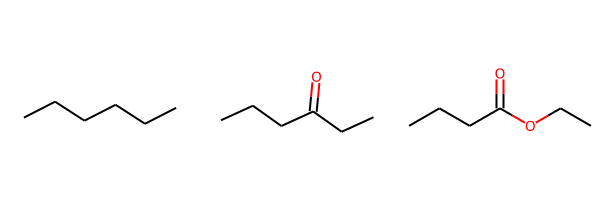

In [18]:
# Get SMILES
smiList = better_canonical.loc[[859, 395, 609]].canonical_smiles
# Create RDKit molecular objects
mols = [Chem.MolFromSmiles(m) for m in smiList]
# display
Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(200,200))